In [95]:
import os
import cv2 as cv
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
IMG_CHANNELS = 3

In [96]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [6]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 7: FSD
TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7))
# MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH1,MASK_PATH7))
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids1,train_ids7))
# mask_ids = np.concatenate((mask_ids8,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids1,mask_ids7))

TRAIN_PATH = np.concatenate((TRAIN_PATH2,TRAIN_PATH5,TRAIN_PATH4,TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7,TRAIN_PATH3))
MASK_PATH = np.concatenate((MASK_PATH2,MASK_PATH5,MASK_PATH4,MASK_PATH6,MASK_PATH1,MASK_PATH7,MASK_PATH3))
train_ids = np.concatenate((train_ids2,train_ids5,train_ids4,train_ids6,train_ids1,train_ids7,train_ids3))
mask_ids = np.concatenate((mask_ids2,mask_ids5,mask_ids4,mask_ids6,mask_ids1,mask_ids7,mask_ids3))

In [38]:
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

TRAIN_PATH = TRAIN_PATH8
train_ids = train_ids8
MASK_PATH = MASK_PATH8
mask_ids= mask_ids8
print(len(train_ids))
print(len(mask_ids))

756
756


In [39]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = img > 30     
    img = img > 0
    img = img.astype(np.uint8)
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

Getting features and labels from images unreshaped... 



 42%|████▏     | 319/756 [01:17<02:08,  3.39it/s]


 83%|████████▎ | 627/756 [03:03<00:49,  2.59it/s]


100%|██████████| 756/756 [03:55<00:00,  2.37it/s]

In [91]:
# print(dat.shape)
# print(np.sum(dat[:,9]))
# np.save('VDM.npy',VDM)
# print(np.unique(dat[:,9]))

In [42]:
# Load the data then shuffle
ABD = np.load('ABD.npy')
np.random.shuffle(ABD)

FSD = np.load('FSD.npy')
np.random.shuffle(FSD)

HGR = np.load('HGR.npy')
np.random.shuffle(HGR)

Pratheep = np.load('Pratheep.npy')
np.random.shuffle(Pratheep)

SCHMG = np.load('SCHMG.npy')
np.random.shuffle(SCHMG)

SFA = np.load('SFA.npy')
np.random.shuffle(SFA)

TDSD = np.load('TDSD.npy')
np.random.shuffle(TDSD)

VDM = np.load('VDM.npy')
np.random.shuffle(VDM)

In [122]:
# Extract and Balance Data
L=np.where(ABD[:,9] > 0)
K = L[0]
skin_abd = ABD[K[:]]
skin_abd = skin_abd[:300000]
L=np.where(ABD[:,9] == 0)
K = L[0]
noskin_abd = ABD[K[:]]
noskin_abd = noskin_abd[:700000]

L=np.where(FSD[:,9] > 0)
K = L[0]
skin_fsd = FSD[K[:]]
skin_fsd = skin_fsd[:30000]
L=np.where(FSD[:,9] == 0)
K = L[0]
noskin_fsd = FSD[K[:]]
noskin_fsd = noskin_fsd[:70000]

L=np.where(HGR[:,9] > 0)
K = L[0]
skin_hgr = HGR[K[:]]
skin_hgr = skin_hgr[:30000]
L=np.where(HGR[:,9] == 0)
K = L[0]
noskin_hgr = HGR[K[:]]
noskin_hgr = noskin_hgr[:70000]

L=np.where(Pratheep[:,9] > 0)
K = L[0]
skin_pra = Pratheep[K[:]]
skin_pra = skin_pra[:30000]
L=np.where(Pratheep[:,9] == 0)
K = L[0]
noskin_pra = Pratheep[K[:]]
noskin_pra = noskin_pra[:70000]

L=np.where(SCHMG[:,9] > 0)
K = L[0]
skin_schmg = SCHMG[K[:]]
skin_schmg = skin_schmg[:30000]
L=np.where(SCHMG[:,9] == 0)
K = L[0]
noskin_schmg = SCHMG[K[:]]
noskin_schmg = noskin_schmg[:70000]

L=np.where(SFA[:,9] > 0)
K = L[0]
skin_sfa = SFA[K[:]]
skin_sfa = skin_sfa[:30000]
L=np.where(SFA[:,9] == 0)
K = L[0]
noskin_sfa = SFA[K[:]]
noskin_sfa = noskin_sfa[:70000]

L=np.where(TDSD[:,9] > 0)
K = L[0]
skin_tdsd = TDSD[K[:]]
skin_tdsd = skin_tdsd[:30000]
L=np.where(TDSD[:,9] == 0)
K = L[0]
noskin_tdsd = TDSD[K[:]]
noskin_tdsd = noskin_tdsd[:70000]

L=np.where(VDM[:,9] > 0)
K = L[0]
skin_vdm = VDM[K[:]]
skin_vdm = skin_vdm[:30000]
L=np.where(VDM[:,9] == 0)
K = L[0]
noskin_vdm = VDM[K[:]]
noskin_vdm = noskin_vdm[:70000]

In [123]:
# Load Shuffled data
alldata = np.concatenate((skin_fsd,noskin_fsd,skin_abd,skin_hgr,skin_pra,skin_schmg,skin_sfa,skin_tdsd,skin_vdm,noskin_abd,noskin_hgr,noskin_pra,noskin_schmg,noskin_sfa,noskin_tdsd,noskin_vdm), axis = 0)
np.random.shuffle(alldata)
print(alldata.shape)
feat = alldata[:,:9]
labels = alldata[:,9]

(1700000, 10)


In [124]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(256,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-unbalanced-12Mar2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.2, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 1360000 samples, validate on 340000 samples
Epoch 1/50
1360000/1360000 [==============================] - 165s 122us/step - loss: 0.2855 - acc: 0.8887 - val_loss: 0.2611 - val_acc: 0.8982

Epoch 00001: val_loss improved from inf to 0.26106, saving model to model-unbalanced-12Mar2019.h5
Epoch 2/50
1360000/1360000 [==============================] - 162s 119us/step - loss: 0.2665 - acc: 0.8965 - val_loss: 0.2849 - val_acc: 0.8834

Epoch 00002: val_loss did not improve from 0.26106
Epoch 3/50
1360000/1360000 [==============================] - 162s 119us/step - loss: 0.2666 - acc: 0.8964 - val_loss: 0.2857 - val_acc: 0.8942

Epoch 00003: val_loss did not improve from 0.26106
Epoch 4/50
1360000/1360000 [==============================] - 163s 120us/step - loss: 0.2688 - acc: 0.8953 - val_loss: 0.3025 - val_acc: 0.8854

Epoch 00004: val_loss did not improve from 0.26106
Epoch 5/50
1360000/1360000 [==============================] - 163s 120us/step - loss: 0.2672 - acc: 0.8961 - val_los


Epoch 00041: val_loss did not improve from 0.25055
Epoch 42/50
1360000/1360000 [==============================] - 163s 120us/step - loss: 0.3161 - acc: 0.8780 - val_loss: 0.2658 - val_acc: 0.9035

Epoch 00042: val_loss did not improve from 0.25055
Epoch 43/50
 418944/1360000 [========>.....................] - ETA: 1:44 - loss: 0.3161 - acc: 0.8693

KeyboardInterrupt: 

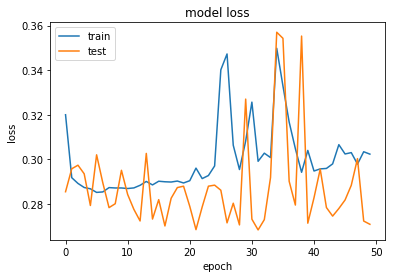

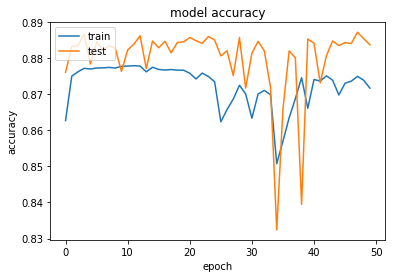

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 3999
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   125.761800    0.862700    0.320000    0.876100    0.285492
1   124.763500    0.875000    0.291800    0.883200    0.295798
2   124.723700    0.876200    0.289200    0.883400    0.297401
3   125.713900    0.877200    0.287400    0.886700    0.293546
4   125.007600    0.877000    0.286800    0.878400    0.279328
5   124.946400    0.877300    0.285200    0.884400    0.302057
6   125.002000    0.877300    0.285400    0.882200    0.289485
7   124.457000    0.877400    0.287300    0.883400    0.278371
8   124.755600    0.877300    0.287200    0.882700    

In [39]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [120]:
# Evaluate the model
model = load_model('model-masturbation2-11Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]

Getting features and labels from images unreshaped... 



100%|██████████| 100/100 [00:07<00:00, 11.46it/s]

In [121]:
scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

14975050/14975050 [==============================] - 817s 55us/step

acc: 94.13%


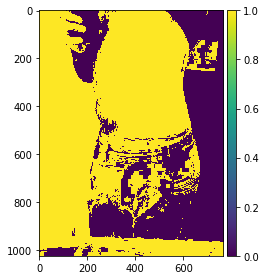

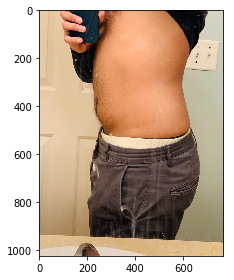

In [48]:
output = np.reshape(preds_test_t,(img.shape[0],img.shape[1]))
plt.show()
imshow(output)
plt.show()
imshow(img)

In [8]:
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)
X = dat[800000:,0:9]
Y = dat[800000:,9]
Y = (Y > 0).astype(np.uint8) 
print(X.shape)
print(Y.shape)

(800000, 9)
(800000,)
(46774033, 9)
(46774033,)
